### **Summary: Support Vector Machines (SVM) for Classification**

**Objective:** Find the optimal separating hyperplane that maximizes the margin between two classes for effective binary classification, especially in high-dimensional spaces.

---

#### **1. The Separating Hyperplane**

In an $n$-dimensional feature space, a hyperplane is defined by a weight vector $\mathbf{w} \in \mathbb{R}^n$ and a bias term $b \in \mathbb{R}$.
$$ \mathbf{w} \cdot \mathbf{x} + b = 0 $$
This hyperplane separates the data if for all training examples $(\mathbf{x}^{(i)}, y^{(i)})$ where $y^{(i)} \in \{-1, +1\}$, the following condition holds:
$$ y^{(i)}(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) > 0 $$

---

#### **2. The Optimal (Maximum-Margin) Hyperplane**

The optimal hyperplane is uniquely defined as the one that **maximizes the margin** ($M$)—the perpendicular distance to the nearest data points from each class. These nearest points are the **support vectors**.

*   The margin is calculated as $M = \frac{2}{\|\mathbf{w}\|}$.
*   Therefore, **maximizing the margin is equivalent to minimizing $\|\mathbf{w}\|$**.

**Optimization Problem (Hard Margin):**
$$
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{minimize}}
& & \frac{1}{2}\|\mathbf{w}\|^2 \\
& \text{subject to}
& & y^{(i)}(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) \geq 1, \quad i = 1, \ldots, m
\end{aligned}
$$
*(The $\frac{1}{2}$ factor is added for mathematical convenience in the subsequent optimization.)*

---

#### **3. Handling Non-Separable Data (Soft Margin)**

For non-linearly separable data or datasets with outliers, we introduce **slack variables** $\zeta^{(i)} \geq 0$ (hinge loss) to allow misclassification. The hyperparameter $C$ controls the trade-off between maximizing the margin and minimizing classification error.

**Optimization Problem (Soft Margin):**
$$
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{minimize}}
& & \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^{m} \zeta^{(i)} \\
& \text{subject to}
& & y^{(i)}(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) \geq 1 - \zeta^{(i)}, \\
& & & \zeta^{(i)} \geq 0, \quad i = 1, \ldots, m
\end{aligned}
$$

**Interpretation of $C$:**
*   **Large $C$**: High penalty for errors. A **stricter** margin, potentially leading to overfitting (low bias, high variance).
*   **Small $C$**: Lower penalty for errors. A **wider**,
 more forgiving margin, potentially leading to underfitting (high bias, low variance).
$C$ is typically tuned via cross-validation.

---

#### **4. Decision Function and Prediction**

Once the optimal $\mathbf{w}$ and $b$ are found (via quadratic programming), the classification of a new sample $\mathbf{x}'$ is given by:
$$ y' = \text{sign}(\mathbf{w} \cdot \mathbf{x}' + b) $$

The magnitude $|\mathbf{w} \cdot \mathbf{x}' + b|$ represents the **distance from the sample to the hyperplane**, which can be interpreted as the **confidence** of the prediction.

---

#### **Practical Use and Notes**

*   **Effectiveness**: Excellent for high-dimensional data (e.g., text classification, image recognition).
*   **Kernel Trick**: The presented formulation is for linear SVM. For non-linear problems, data is mapped to a higher-dimensional space using a kernel function (e.g., RBF, polynomial) where it becomes linearly separable, without explicitly computing the coordinates in that space.
*   **Implementation**: Efficiently solved by libraries like `scikit-learn` (`LinearSVC`, `SVC`), which are based on `liblinear` and `libsvm`.
*   **Multiclass Classification**: Native binary classifier. Multiclass problems are handled using one-vs-rest or one-vs-one strategies.

# Implementing SVM

1. We first load the dataset and do some basic analysis, as follows:

In [1]:
from sklearn.datasets import load_breast_cancer

cancer_data = load_breast_cancer()
X = cancer_data.data
Y = cancer_data.target

print("Input data size :  ", X.shape)
print("Ouptput data size : ",Y.shape)

print('Label names:', cancer_data.target_names)

n_pos = (Y==1).sum()
n_neg =  (Y==0).sum()

print(f'{n_pos} positive samples and {n_neg} negative samples.')

Input data size :   (569, 30)
Ouptput data size :  (569,)
Label names: ['malignant' 'benign']
357 positive samples and 212 negative samples.


2. Next, we split the data into training and testing sets:

In [2]:
from sklearn.model_selection import train_test_split

X_train , X_test, Y_train , Y_test  = train_test_split(X,Y , random_state=42)

3. We can now apply the SVM classifier to the data. We first initialize an SVC model with the kernel parameter set to linear (linear kernel refers to the use of a linear decision boundary to separate classes in the input space. I will explain what kernel means in Scenario 5) and the penalty hyperparameter C set to the default value, 1.0:

In [3]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=1.0 , random_state= 42)

4. We then fit our model on the training set, as follows:

In [4]:
clf.fit(X_train,Y_train)

SVC(kernel='linear', random_state=42)

5. Then, we predict on the testing set with the trained model and obtain the prediction accuracy directly:

In [5]:
accuracy = clf.score(X_test, Y_test)

print(f'The accuracy is: {accuracy*100:.1f}%')


The accuracy is: 95.8%


Our first SVM model works just great, achieving an accuracy of 95.8%. How about dealing with more
than two topics? How does SVM handle multiclass classification?

# Scenario 4 – dealing with more than two classes

### **Summary: Multiclass SVM Strategies**

The native SVM is a binary classifier. Two primary strategies extend it to **K-class** problems.

---

#### **1. One-vs-Rest (OvR) / One-vs-All**

**Concept:** Train **K** separate binary classifiers. For each class $k$, the classifier is trained to distinguish that class (*positive*) from all other classes combined (*negative*).

*   **Classifier for class $k$:** Learns hyperplane parameters $(\mathbf{w}_k, b_k)$.
*   **Decision Function:** For a new sample $\mathbf{x'}$, each classifier $k$ computes its decision score: $f_k(\mathbf{x'}) = \mathbf{w}_k \cdot \mathbf{x'} + b_k$.
*   **Prediction:** The class with the **highest score** is chosen, regardless of the sign. The score's magnitude represents confidence.
$$ y' = \underset{k \in \{1, ..., K\}}{\text{argmax}}  (\mathbf{w}_k \cdot \mathbf{x'} + b_k) $$

**Characteristics:**
*   **Number of classifiers:** $K$
*   Each classifier is trained on the **entire dataset**.

---

#### **2. One-vs-One (OvO)**

**Concept:** Train a binary classifier for **every pair** of distinct classes. This results in $\frac{K(K-1)}{2}$ classifiers.

*   **Classifier for classes $(i, j)$:** Learns hyperplane parameters $(\mathbf{w}_{ij}, b_{ij})$ using **only the data from classes $i$ and $j$**.
*   **Prediction:** For a new sample $\mathbf{x'}$, each pairwise classifier casts a *vote* for the class it predicts. The class that receives the **most votes** wins.

**Characteristics:**
*   **Number of classifiers:** $\frac{K(K-1)}{2}$ (grows quadratically with $K$).
*   Each classifier is trained on a **small subset** of the data (only two classes), making individual training steps faster and more memory-efficient.

---

#### **Comparison & Practical Choice**

| Feature | One-vs-Rest (OvR) | One-vs-One (OvO) |
| :--- | :--- | :--- |
| **Classifiers Trained** | $K$ | $\frac{K(K-1)}{2}$ |
| **Training Data per Classifier** | Entire dataset | Subset (2 classes only) |
| **Computational Profile** | Fewer, larger training problems | More, smaller training problems |
| **Practical Preference** | | Often preferred for kernel SVMs or large $K$ as the smaller training sets are more efficient. |

In practice, both strategies often achieve comparable accuracy. The choice is largely **computational**:
*   **OvO** is generally more efficient for large datasets or complex kernels because each individual training task is much smaller and faster, despite there being more of them.
*   Scikit-learn's `SVC` class uses the One-vs-One strategy by default.

## Multiclass cases in scikit-learn

1. We first load the dataset and do some basic analysis, as follows:

In [6]:
from sklearn.datasets import load_wine

wine_data = load_wine()
X= wine_data.data
Y = wine_data.target
print('Input data sie : ', X.shape)
print('Outpup data sie :', Y.shape)
print('Labels names : ' ,wine_data.target_names)

n_class0 = (Y == 0).sum()
n_class1 = (Y == 1).sum()
n_class2 = (Y == 2).sum()

print(f'{n_class0} class0 samples,\n{n_class1} class1 samples,\n{n_class2} class2 samples.')

Input data sie :  (178, 13)
Outpup data sie : (178,)
Labels names :  ['class_0' 'class_1' 'class_2']
59 class0 samples,
71 class1 samples,
48 class2 samples.


As you can see, the dataset has 178 samples with 13 features; its label has three possible values
taking up 33%, 40%, and 27%, respectively

2. Next, we split the data into training and testing sets:

In [7]:
X_train , X_test , Y_train , Y_test = train_test_split(X, Y , random_state=42)

3. We can now apply the SVM classifier to the data. We first initialize an SVC model and fit it
against the training set:

In [8]:
clf = SVC(kernel='linear',C =1.0 , random_state=42)
clf.fit(X_train, Y_train)

SVC(kernel='linear', random_state=42)

In an SVC model, multiclass support is implicitly handled according to the one-vs-one scheme.

4. Next, we predict on the testing set with the trained model and obtain the prediction accuracy
directly:

In [9]:
accuracy =  clf.score(X_test,Y_test)
print(f'The accuracy is {accuracy*100:.1f}%')

The accuracy is 97.8%


Our SVM model also works well in this multiclass case, achieving an accuracy of 97.8%.

5. We also check how it performs for individual classes:

In [10]:
from sklearn.metrics import classification_report
pred = clf.predict(X_test)
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



It looks excellent! Is the example too easy? Maybe. What do we do in tricky cases? Of course, we could
tweak the values of the kernel and C hyperparameters. As discussed, factor C controls the strictness
of separation, and it can be tuned to achieve the best trade-off between bias and variance. How about
the kernel? What does it mean and what are the alternatives to a linear kernel?
In the next section, we will answer those two questions we just raised. You will see how the kernel
trick makes SVM so powerful.

# Scenario 5 – solving linearly non-separable problems with kernels

Of course. Here is a summary of the kernel method for SVMs, focusing on the mathematical intuition and practical selection criteria, formatted for clarity.

***

### **Summary: Non-Linear SVMs & The Kernel Trick**

**Problem:** A linear hyperplane is insufficient for non-linearly separable data.

**Solution:** Map the original feature space $\mathbf{x} \in \mathbb{R}^n$ to a higher-dimensional space $\phi(\mathbf{x}) \in \mathbb{R}^d$ where the data *becomes* linearly separable. A separating hyperplane $(\mathbf{w}_\phi, b_\phi)$ is then learned in this new space.

---

#### **1. The Kernel Trick**

The mapping $\phi$ is powerful but computationally expensive. The **kernel trick** provides an efficient workaround.

*   The SVM optimization problem only requires the computation of **pairwise dot products** $\langle \phi(\mathbf{x}^{(i)}), \phi(\mathbf{x}^{(j)}) \rangle$ in the high-dimensional space.
* A **kernel function** $K$ is a function that computes this dot product *directly* from the original vectors, **without explicitly performing the transformation**:

  $$K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = \langle \phi(\mathbf{x}^{(i)}), \phi(\mathbf{x}^{(j)}) \rangle$$

* This allows SVMs to learn non-linear decision boundaries with the computational cost of a linear model.

---

#### **2. Common Kernel Functions**

*   **Radial Basis Function (RBF) / Gaussian Kernel:**
    $$
    K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = \exp\left(-\gamma ||\mathbf{x}^{(i)} - \mathbf{x}^{(j)}||^2 \right)
    $$
    *   **Parameter $\gamma$:** Controls the influence of a single training example.
        *   **Large $\gamma$** (narrow kernel): Decision boundary is very sensitive to data points, leading to complex, potentially **overfit** models.
        *   **Small $\gamma$** (wide kernel): Decision boundary is smoother, leading to simpler, potentially **underfit** models.
    *   $\gamma$ is a critical hyperparameter to tune via cross-validation.

*   **Polynomial Kernel:**
    $$
    K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = (\langle \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \rangle + r)^d
    $$
    *   **Parameters:** Degree $d$, coefficient $r$.

*   **Sigmoid Kernel:**
    $$
    K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = \tanh(\langle \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \rangle + r)
    $$

In practice, the **RBF kernel is most commonly used** as a default starting point due to its flexibility and strong performance.

---

#### **3. Practical Kernel Selection Guidelines**

Choosing between a **linear kernel** ($K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = \langle \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \rangle$) and an **RBF kernel** is a key decision.

**Prefer a Linear Kernel when:**

1.  **Both the number of features ($n$) and samples ($m$) are very large** (e.g., $> 10^4$). The data is often already separable in the high-dimensional original space, and the linear kernel is more efficient.
2.  **The number of features far exceeds the number of samples** ($n \gg m$). Using a non-linear kernel like RBF in this setting greatly increases the risk of overfitting.
3.  **The number of samples is extremely large** (e.g., $m > 10^6$). Training with an RBF kernel can become computationally prohibitive. A linear model is more scalable.
4.  **There is prior knowledge that the data is linearly separable** (e.g., often the case with text data).

**Prefer an RBF Kernel when:**

*   **None of the above conditions are met.** This is the most common scenario.
*   **The data is known to be non-linearly separable** (e.g., XOR-type problems).
*   **The data is low-dimensional** and a complex decision boundary is suspected. The RBF kernel can provide a significant performance boost.

To illustrate this trade-off, let’s apply the RBF kernel with different values to a toy dataset:

In [11]:
import numpy as np
import matplotlib.pyplot as plt

X = np.c_[#negative class
            (.3 , -.8),
            (-1.5 , -1),
            (-1.3, -.8),
            (-1.1, -1.3),
            (-1.2, -.3),
            (-1.3, -.5),
            (-.6, 1.1),
            (-1.4, 2.2),
            (1, 1),
            # positive class
            (1.3, .8),
            (1.2, .5),
            (.2, -2),
            (.5, -2.4),
            (.2, -2.3),
            (0, -2.7),
            (1.3, 2.1)].T

Y = [-1] * 8 + [1] * 8

Eight data points are from one class, and eight are from another. We take three values, 1, 2, and 4, for
kernel coefficient options as an example:

In [12]:
gamma_option = [1, 2, 4]

Under each kernel coefficient, we fit an individual SVM classifier and visualize the trained decision
boundary:

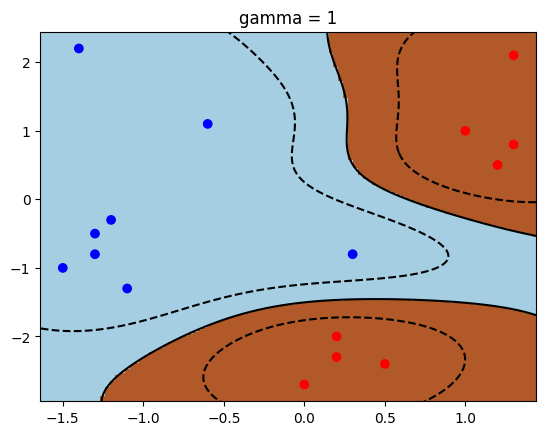

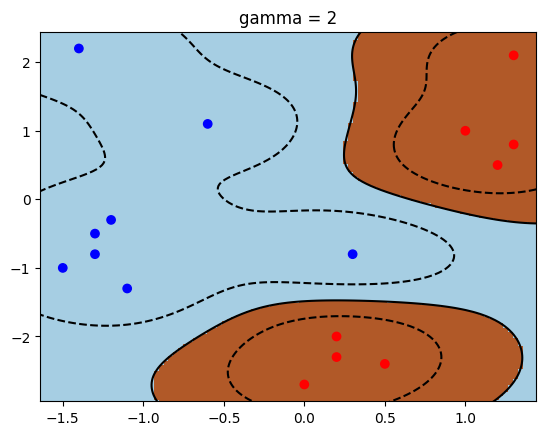

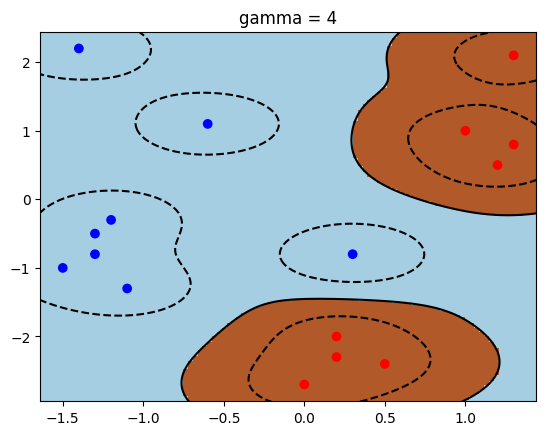

In [13]:
for i, gamma in enumerate(gamma_option, 1):
    svm = SVC(kernel='rbf', gamma=gamma)
    svm.fit(X, Y)
    plt.scatter(X[:, 0], X[:, 1], c=['b']*8+['r']*8, zorder=10)
    plt.axis('tight')
    XX, YY = np.mgrid[-3:3:200j, -3:3:200j]
    Z = svm.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0 , cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
    linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
    plt.title('gamma = %d' % gamma)
    plt.show()

In the absence of prior knowledge of the distribution, the RBF kernel is usually preferable in practical
usage, as there is an additional parameter to tweak in the polynomial kernel (polynomial degree d),
and the empirical sigmoid kerne

### Choosing between linear and RBF kernels

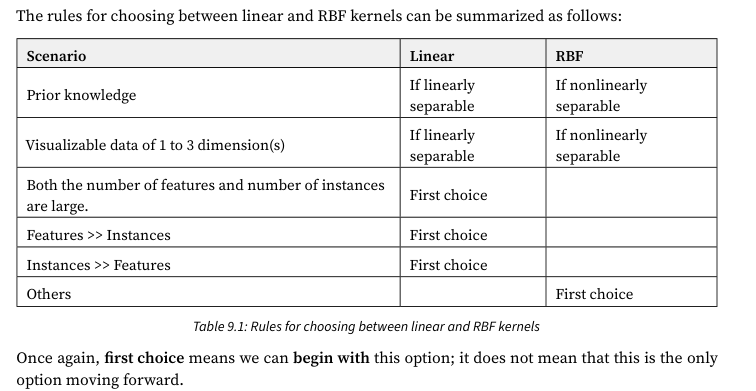

# Classifying face images with SVM

First, we load the face image data as follows:

In [14]:
from sklearn.datasets import fetch_lfw_people
face_data = fetch_lfw_people(min_faces_per_person=80)

In [17]:
!pip install pillow

In [19]:
face_data = fetch_lfw_people(data_home='./',
                             min_faces_per_person=80,
                             download_if_missing=True )

In [20]:
X = face_data.data
Y = face_data.target
print('Input data size :', X.shape)
print('Output data size : ', Y.shape)
print('Label names : ', face_data.target_names)


Input data size : (1140, 2914)
Output data size :  (1140,)
Label names :  ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


This five-class dataset contains 1,140 samples and a sample is of 2,914 dimensions. As a good practice,
we analyze the label distribution as follows:

In [21]:
for i in range(5):
    print(f'Class {i} has {(Y == i).sum()} samples.')

Class 0 has 236 samples.
Class 1 has 121 samples.
Class 2 has 530 samples.
Class 3 has 109 samples.
Class 4 has 144 samples.


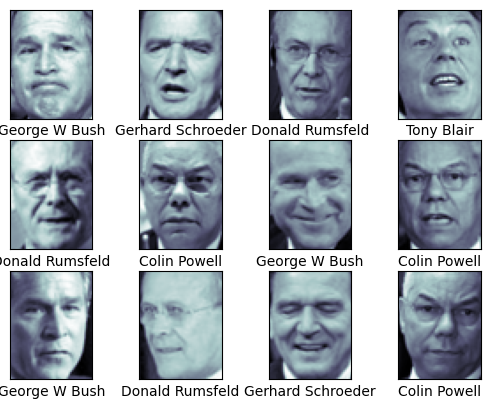

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 4)
for i , axi in enumerate(ax.flat):
    axi.imshow(face_data.images[i],cmap='bone')
    axi.set(xticks=[],yticks=[],
            xlabel = face_data.target_names[face_data.target[i]])

plt.show()

the dataset is rather imbalanced. Let’s keep this in mind when we build the model.

## Building an SVM-based image classifier

#### In this project, the number of dimensions is greater than the number of samples. This is a classificationcase that SVM is effective at solving. In our solution, we will tune the hyperparameters, including the penalty C, the kernel (linear or RBF), and 𝛾𝛾 (for the RBF kernel) through cross-validation.

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [24]:
clf = SVC(class_weight='balanced', random_state=42)

The dataset is imbalanced, so we set class_weight='balanced' to emphasize the underrepresented
classes.

------------------------------------------------------------

We utilize the GridSearchCV module from scikit-learn to search for the best combination of hyperparameters over several candidates. We will explore the following hyperparameter candidates:

In [39]:
parameters = {'C': [10,100,300],
              'gamma': [0.0001 , 0.0003 , 0.001],
              'kernel' : ['rbf', 'linear']}
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(clf, parameters , n_jobs=-1 , cv=5)

The GridSearchCV model we just initialized will conduct five-fold cross-validation (cv=5) and will run
in parallel on all available cores (n_jobs=-1). We then perform hyperparameter tuning by simply
applying the fit method

In [40]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'C': [10, 100, 300], 'gamma': [0.0001, 0.0003, 0.001],
                         'kernel': ['rbf', 'linear']})

the optimal set of hyperparameters using the following code:

In [41]:
print('The best model:\n', grid_search.best_params_)

The best model:
 {'C': 300, 'gamma': 0.001, 'kernel': 'rbf'}


we obtain the best five-fold averaged performance under the optimal set of parameters by using
the following code:

In [42]:
print('The best averaged performance:', grid_search.best_score_)

The best averaged performance: 0.8456140350877192


We then retrieve the SVM model with the optimal set of hyperparameters and apply it to the testing set:

In [44]:
clf_best = grid_search.best_estimator_
pred = clf_best.predict(X_test)


We then calculate the accuracy and classification report:

In [45]:
print(f'The accuracy is: {clf_best.score(X_test,Y_test)*100:.1f}%')

from sklearn.metrics import classification_report
print(classification_report(Y_test, pred,
                                target_names=face_data.target_names))

The accuracy is: 89.8%
                   precision    recall  f1-score   support

     Colin Powell       0.90      0.88      0.89        64
  Donald Rumsfeld       0.90      0.84      0.87        32
    George W Bush       0.89      0.94      0.92       127
Gerhard Schroeder       0.90      0.90      0.90        29
       Tony Blair       0.90      0.85      0.88        33

         accuracy                           0.90       285
        macro avg       0.90      0.88      0.89       285
     weighted avg       0.90      0.90      0.90       285



## Boosting image classification performance with PCA


### **Summary: Enhancing SVM Classification with PCA**

**Objective:** Improve SVM classifier performance (especially in high-dimensional spaces like images) by reducing dimensionality with Principal Component Analysis (PCA) to prevent overfitting and reduce computational cost.

#### **Why PCA + SVM Works**
*   **Dimensionality Reduction:** PCA projects original features onto a lower-dimensional space defined by the principal components (PCs) that capture the maximum variance.
*   **Prevents Overfitting:** By focusing on the most significant patterns and reducing noise, PCA helps create a more robust model, particularly when the number of features exceeds the number of samples.
*   **Efficiency:** Training an SVM on a reduced feature set is computationally faster.

#### **The PCA-SVM Pipeline Workflow**
The process is implemented as a scikit-learn `Pipeline` to ensure proper data flow and avoid data leakage during cross-validation.

| Pipeline Stage | Component | Key Parameters & Role |
| :--- | :--- | :--- |
| **1. Preprocessing** | (Implicit) | Data is standardized (mean-centered and scaled) **before** PCA. This is crucial as PCA is sensitive to feature scales. |
| **2. Dimensionality Reduction** | `PCA` | `n_components`: Number of top PCs to keep (e.g., 100). `whiten=True`: Scales the transformed data to have unit variance, which can often improve SVM performance. |
| **3. Classification** | `SVC` | `kernel='rbf'`: Uses the Gaussian kernel for non-linear separation. `class_weight='balanced'`: Adjusts weights to handle imbalanced classes. |

#### **Practical Implementation & Results**
A grid search (`GridSearchCV`) is used to find the best hyperparameters for the entire pipeline.
*   **Search Parameters:** `svc__C` (regularization) and `svc__gamma` (RBF kernel influence) are tuned.
*   **Result:** The combined PCA-SVM model achieved **92.3% accuracy** on the test set, a significant improvement over a standard SVM model, demonstrating the effectiveness of this approach for image classification tasks.

#### **Best Practices for Tuning**
1.  **Coarse-to-Fine Search:** Start with a wide range of `C` and `gamma` values to identify promising regions before refining the search.
2.  **Prior Knowledge:** Use domain insight to guide initial values (e.g., a larger `C` for noisier data).
3.  **Cross-Validation:** Always use CV within the grid search to evaluate performance reliably and avoid overfitting the validation set.
4.  **Iterative Refinement:** Based on initial results, narrow down the hyperparameter ranges for a more focused and efficient search.

In machine learning, we usually concatenate multiple consecutive steps and treat them as one “model.”
We call this process pipelining. We utilize the pipeline API (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) from scikit-learn to facilitate this.

Now, let’s initialize a PCA model, an SVC model, and a model pipelining these two:

In [46]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
pca = PCA(n_components=100,
          whiten = True ,
          random_state=42)

svc = SVC(class_weight='balanced',
          kernel='rbf',
          random_state=42)

from sklearn.pipeline import Pipeline

model = Pipeline([('pca',pca),
                  ('svc', svc)])



The PCA component projects the original data into a 100-dimension space, followed by the SVC classifier with the RBF kernel. We then perform a grid search for the best model among a few options:

In [48]:
parameters_pipeline = {
                       'svc__C': [1,3,10],
                       'svc__gamma': [0.01,0.03,0.003]
                       }

grid_search = GridSearchCV(model, parameters_pipeline, n_jobs=-1,cv=5)

grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=100, random_state=42,
                                            whiten=True)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 3, 10],
                         'svc__gamma': [0.01, 0.03, 0.003]})

Finally, we print out the best set of hyperparameters and the classification performance with the best
model:

In [49]:
print('The best model:\n', grid_search.best_params_)


print('The best averaged perfoace ', grid_search.best_score_)

model_best = grid_search.best_estimator_

print(f'The accuracy is: {model_best.score(X_test, Y_test)*100:.1f}%')

pred = model_best.predict(X_test)
print(classification_report(Y_test,
                            pred,
                            target_names=face_data.target_names))

The best model:
 {'svc__C': 1, 'svc__gamma': 0.01}
The best averaged perfoace  0.8631578947368419
The accuracy is: 92.3%
                   precision    recall  f1-score   support

     Colin Powell       0.94      0.94      0.94        64
  Donald Rumsfeld       0.93      0.84      0.89        32
    George W Bush       0.91      0.97      0.94       127
Gerhard Schroeder       0.92      0.79      0.85        29
       Tony Blair       0.94      0.91      0.92        33

         accuracy                           0.92       285
        macro avg       0.93      0.89      0.91       285
     weighted avg       0.92      0.92      0.92       285



# Estimating with support vector regression

### **Summary: Support Vector Regression (SVR)**

**Objective:** To find a function $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$ that deviates from the actual target values $y^{(i)}$ by no more than a predefined margin $\epsilon$ for all training data, while being as flat as possible.

#### **1. Core Intuition and Mathematical Formulation**

SVR is the regression counterpart to the Support Vector Machine (SVC). Instead of finding a hyperplane that separates classes with a maximum margin, SVR finds a hyperplane that fits as many data points as possible within a "tube" of width $\epsilon$.

*   **The $\epsilon$-insensitive tube:** The model does not penalize predictions that lie within $\epsilon$ distance from the true value. Only points outside this tube contribute to the loss.
*   **Flatness:** The flatness of the model is achieved by minimizing the norm of the weight vector $||\mathbf{w}||$, which prevents overfitting and encourages simplicity.

**Optimization Problem:**
$$
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{minimize}}
& & \frac{1}{2}||\mathbf{w}||^2 \\
& \text{subject to}
& & |y^{(i)} - (\mathbf{w} \cdot \mathbf{x}^{(i)} + b)| \leq \epsilon, \quad \text{for } i = 1, \ldots, m
\end{aligned}
$$

In practice, a "soft margin" version is used, which introduces **slack variables** $\zeta^{(i)}$ to allow for outliers and make the optimization feasible for non-linear data.

#### **2. Key Concepts and Transfer from SVC**

| Concept | In SVC (Classification) | In SVR (Regression) |
| :--- | :--- | :--- |
| **Goal** | Maximize margin between classes. | Fit data within an $\epsilon$-tube. |
| **Hyperplane** | Decision boundary. | Regression function. |
| **Support Vectors** | Points on the margin. | Points outside the $\epsilon$-tube. |
| **Kernel Trick** | Handles non-linear class boundaries. | Handles non-linear relationships. |
| **Parameter `C`** | Trade-off between margin width and misclassification. | Trade-off between flatness and deviations > $\epsilon$. |

#### **3. Practical Implementation with `scikit-learn`**

The key hyperparameters for `sklearn.svm.SVR` are directly analogous to those in `SVC`:

*   **`kernel`**: The kernel type (e.g., `'rbf'`, `'linear'`, `'poly'`). `'rbf'` is a common default.
*   **`C`**: Regularization parameter. A larger `C` forces the model to fit the training data more closely, potentially leading to overfitting. A smaller `C` allows for a flatter function, potentially leading to underfitting.
*   **`epsilon`**: The width of the $\epsilon$-insensitive tube. A larger `epsilon` means fewer support vectors and a smoother function.
*   **`gamma`** (for RBF kernel): Defines the influence of a single training example. Low values mean ‘far’, high values mean ‘close’. A high `gamma` can lead to overfitting.

**Typical Workflow:**
1.  Standardize the features (crucial for SVM models).
2.  Initialize the `SVR` model with a chosen kernel (e.g., `kernel='rbf'`).
3.  Use `GridSearchCV` or `RandomizedSearchCV` to find the optimal combination of `C`, `epsilon`, and `gamma`.
4.  Train the model on the best found parameters and evaluate its performance.

SVR is particularly powerful for modeling complex, non-linear relationships but requires careful tuning of its hyperparameters to achieve optimal performance.

## Implementing SVR

1. Initially, we load the dataset and check the data size, as follows:

In [50]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
X = diabetes.data
Y = diabetes.target
print("Input data size :  ", X.shape)
print("Ouptput data size : ",Y.shape)



Input data size :   (442, 10)
Ouptput data size :  (442,)


2. Next, we designate the last 30 samples as the testing set, while the remaining samples serve
as the training set:

In [51]:
num_test  = 30
X_train = diabetes.data[:-num_test, :]
y_train = diabetes.target[:-num_test]
X_test = diabetes.data[-num_test:, :]
y_test = diabetes.target[-num_test:]

3. We can now apply the SVR regressor to the data. We first initialize an SVC model and fit it
against the training set:

In [52]:
from sklearn.svm import SVR

regressor = SVR(C=100, kernel='linear')
regressor.fit(X_train,y_train)

SVR(C=100, kernel='linear')

4. We predict on the testing set with the trained model and obtain the prediction performance:

In [53]:
from sklearn.metrics import r2_score

predictions = regressor.predict(X_test)
print(r2_score(y_test,predictions))


0.5868189735154503


5. Let’s further improve it with a grid search to find the best model from the following options:

In [54]:
from sklearn.model_selection import GridSearchCV

parameters = {'C' :[300,500,700],
             'gamma' : [0.3,0.6,1],
             'kernel': ['rbf', 'linear']}

regressor  = SVR()

grid_search = GridSearchCV(regressor ,
                           parameters ,
                           n_jobs =-1,
                           cv =5)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [300, 500, 700], 'gamma': [0.3, 0.6, 1],
                         'kernel': ['rbf', 'linear']})